# Homework 1 (include all parts from challenge 1+optional, 2 and homework)
Authors:
- Nazarii Drushchak
- Igor Babin
- Uliana Zbezhkhovska

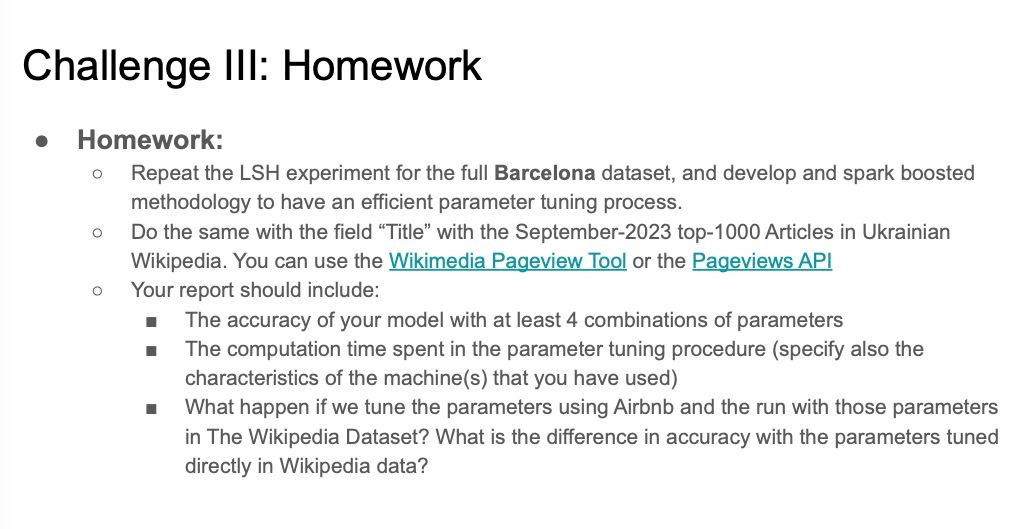

In [5]:
!pip install findspark

In [6]:
import findspark
findspark.init()

In [7]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.feature import MinHashLSH
from pyspark.sql.functions import col, avg, when
from pyspark.ml.feature import HashingTF, IDF, Tokenizer, StopWordsRemover
from pyspark.ml.feature import Word2Vec
from sklearn.neighbors import NearestNeighbors
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [8]:
sc = pyspark.SparkContext('local[*]')
spark = SparkSession(sc)
spark

## Challenge I

In [5]:
!wget http://data.insideairbnb.com/the-netherlands/north-holland/amsterdam/2023-09-03/visualisations/listings.csv

'wget' is not recognized as an internal or external command,
operable program or batch file.


In [34]:
df = spark.read.csv("listings.csv", header=True, multiLine=True)
df.show(5)

+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+
|    id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             license|
+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+
|761411|Condo in Amsterda...|4013546|   Xsjong|               NULL|   Noord-Oost|52.40164|  4.95106|   Private room|   61|             3|              303| 2023-08-19|  

Tokenize (remove punctuation and split by word), you can do it in pure python or using ml-lib tokenizer

In [35]:
tokenizer = Tokenizer(inputCol="name", outputCol="words")
wordData = tokenizer.transform(df)
wordData.show(5)

+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+
|    id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             license|               words|
+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+
|761411|Condo in Amsterda...|4013546|   Xsjong|               NULL|   Noord-Oost|52.40164|  4.95106|   Pri

Remove stopwords using ML-LIB stopwordsremover, and store in a new column called “CleanTokens”

In [36]:
remover = StopWordsRemover(inputCol="words", outputCol="CleanTokens")
cleanData = remover.transform(wordData)
cleanData.show(5)

+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+--------------------+
|    id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             license|               words|         CleanTokens|
+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+--------------------+
|761411|Condo in Amsterda...|4013546|   Xsj

But we don’t have a stopwordsremover for all language and contexts. Create your own list of stopwords from this text (think: what is a stopword?) Remove stopwords again, and store in column “MyCleanTokens”

In [37]:
stop_list = ['the', 'a', 'an', 'another', "for", "an", "nor", "but", "or", "yet", "so", 
                                      "in", "under", "towards", "before"]
remover = StopWordsRemover(stopWords=stop_list, inputCol='words', outputCol='MyCleanTokens')
cleanData = remover.transform(cleanData)
cleanData.show(5)

+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|    id|                name|host_id|host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             license|               words|         CleanTokens|       MyCleanTokens|
+------+--------------------+-------+---------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+--------------------+--

Perform TFIDF in a new column called “VectorSpace”

In [38]:
hashingTF = HashingTF(inputCol="MyCleanTokens", outputCol="VectorSpace", numFeatures=20)
featurizedData = hashingTF.transform(cleanData)

idf = IDF(inputCol="VectorSpace", outputCol="features")
idfModel = idf.fit(featurizedData)
results = idfModel.transform(featurizedData)

results.select("MyCleanTokens", "features").show(5)

+--------------------+--------------------+
|       MyCleanTokens|            features|
+--------------------+--------------------+
|[condo, amsterdam...|(20,[1,2,7,10,11,...|
|[rental, unit, am...|(20,[1,2,5,11,12,...|
|[boat, amsterdam,...|(20,[0,1,2,5,11,1...|
|[houseboat, amste...|(20,[0,1,5,6,11,1...|
|[rental, unit, am...|(20,[1,2,9,11,12,...|
+--------------------+--------------------+
only showing top 5 rows



## Homework (Optional)

In a new column(‘word2vec’), repeat the procedure using word2vec instead of TF-IDF.

In [39]:
word2Vec = Word2Vec(vectorSize=20, minCount=0, inputCol="MyCleanTokens", outputCol="word2vec")
model = word2Vec.fit(results)
result = model.transform(results)

result.select("MyCleanTokens", "word2vec").show(5)

+--------------------+--------------------+
|       MyCleanTokens|            word2vec|
+--------------------+--------------------+
|[condo, amsterdam...|[-0.1877061312219...|
|[rental, unit, am...|[-0.4727530359689...|
|[boat, amsterdam,...|[-0.3377536280223...|
|[houseboat, amste...|[-0.4983324660704...|
|[rental, unit, am...|[-0.2360467803974...|
+--------------------+--------------------+
only showing top 5 rows



Show first row word2vec vector

In [40]:
result.select("word2vec").first()

Row(word2vec=DenseVector([-0.1877, 0.2873, 0.1531, 0.0396, 0.1707, 0.0639, -0.4473, -0.4199, 0.1317, 0.1349, 0.3693, 0.0212, -0.0975, -0.0355, -0.4143, -0.3659, -0.2129, 0.3557, 0.3055, 0.1669]))

## Challenge II

Take the first 500 flats in the list

In [41]:
mysample = result.limit(500)
mysample.count()

500

Find the 3 nearest neighbors for each element in that subset (candidates and query points are within the sample of 500) USING KNN

In [42]:
mysample.show()

+-------+--------------------+-------+---------------+-------------------+--------------------+------------------+----------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|     id|                name|host_id|      host_name|neighbourhood_group|       neighbourhood|          latitude|       longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             license|               words|         CleanTokens|       MyCleanTokens|         VectorSpace|            features|            word2vec|
+-------+--------------------+-------+---------------+-------------------+--------------------+------------------+----------------+-

In [135]:
mysample_pd = mysample.toPandas()
tfidf = mysample_pd['features'].tolist()
text = mysample_pd['name'].tolist()
id_ = mysample_pd['id'].tolist()

# fit nearest neighbors
nbrs = NearestNeighbors(n_neighbors=4).fit(tfidf)
distances, indices = nbrs.kneighbors(tfidf[:5])

# show 3 nearest neighbors for first row except itself
print('id', [id_[i] for i in indices[0]])

id ['761411', '634170', '721291', '730916']


Find the 3 nearest neighbors for each element in that subset (candidates and query points are within the sample of 500) USING LSH with sklearn

In [48]:
# IT IS DEPRECATED or Install 3 years old version of sklearn 0.16.1
try:
    from sklearn.neighbors import LSHForest
    
    mysample_pd = mysample.toPandas()
    tfidf = mysample_pd['features'].tolist()
    text = mysample_pd['name'].tolist()
    id_ = mysample_pd['id'].tolist()
    
    lshf = LSHForest(random_state=42)
    lshf.fit(tfidf)
    
    # get the feature vectore of the first row
    query = tfidf[0]
    id_ = id_[0]
    
    # show 3 nearest neighbors for first row except itself
    distances, indices = lshf.kneighbors([query], n_neighbors=4)
    for i in range(1, len(distances[0])):
        print("distance: ", distances[0][i], "id: ", id_[indices[0][i]])
except ImportError:
    print("LSHForest could not be imported")

LSHForest could not be imported


Find the 3 nearest neighbors for each element in that subset (candidates and query points are within the sample of 500) USING LSH with pyspark

In [49]:
mh = MinHashLSH(inputCol="features", outputCol="hashes", numHashTables=3)
model = mh.fit(mysample)

# get the feature vector of the first row
key =  mysample.select("features").take(1)[0].features
id_ = mysample.select("id").take(1)[0].id


# show 3 nearest neighbors for first row except itself
model.approxNearestNeighbors(mysample, key, 4).filter(col("id") != id_).show()

+-------+--------------------+-------+----------------+-------------------+-------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+
|     id|                name|host_id|       host_name|neighbourhood_group|neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|             license|               words|         CleanTokens|       MyCleanTokens|         VectorSpace|            features|            word2vec|              hashes|           distCol|
+-------+--------------------+-------+----------------+-------------------+-------------+--------+

## Challenge III: Homework

Repeat the LSH experiment for the full Barcelona dataset, and develop and spark boosted methodology to have an efficient parameter tuning process.

In [23]:
!wget http://data.insideairbnb.com/spain/catalonia/barcelona/2023-09-06/visualisations/listings.csv -O listings_barcelona.csv 

--2023-10-20 10:28:43--  http://data.insideairbnb.com/spain/catalonia/barcelona/2023-09-06/visualisations/listings.csv
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.217.46.139, 52.216.42.125, 52.216.106.82, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.217.46.139|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3664972 (3.5M) [application/csv]
Saving to: ‘listings_barcelona.csv’

listings_barcelona. 100%[===================>]   3.50M  2.39MB/s    in 1.5s    

2023-10-20 10:28:45 (2.39 MB/s) - ‘listings_barcelona.csv’ saved [3664972/3664972]



In [50]:
df = spark.read.csv("listings_barcelona.csv", header=True, multiLine=True)
df.show(5)

+------+--------------------+-------+----------------+-------------------+--------------------+-----------------+-----------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-----------+
|    id|                name|host_id|       host_name|neighbourhood_group|       neighbourhood|         latitude|        longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|number_of_reviews_ltm|    license|
+------+--------------------+-------+----------------+-------------------+--------------------+-----------------+-----------------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+---------------------+-----------+
| 18674|Rental unit in Ba...|  71615|Mireia And Maria|           Eixample|  la Sagrada Família|        

In [52]:
df.count()

18086

# Annoy

- AnnoyIndex(f, metric) returns a new index that's read-write and stores vector of f dimensions. Metric can be "angular", "euclidean", "manhattan", "hamming", or "dot".


In [197]:
from annoy import AnnoyIndex
from sklearn.metrics import f1_score
metric = ['angular', 'euclidean', "hamming", "manhattan"]
n_tree = [20, 60, 400, 1000]

In [202]:

f=20
for met in metric:
    for tree in n_tree:
        annoy = []
        t = AnnoyIndex(f, met)
        for i in range(mysample_pd.shape[0]):
            t.add_item(i,mysample_pd['word2vec'][i].values.tolist())
        t.build(tree, n_jobs=-1)
        for i in range(mysample_pd.shape[0]):
            annoy.append(t.get_nns_by_vector(mysample_pd['word2vec'][i], 4))
        print(f"For metric {met} and n_tree {tree} accuracy is {np.mean([f1_score(indices.tolist()[i], annoy[i], average='weighted') for i in range(mysample_pd.shape[0])])}")
        
            

For metric angular and n_tree 20 accuracy is 0.2405
For metric angular and n_tree 60 accuracy is 0.2405
For metric angular and n_tree 400 accuracy is 0.2405
For metric angular and n_tree 1000 accuracy is 0.2405
For metric euclidean and n_tree 20 accuracy is 0.242
For metric euclidean and n_tree 60 accuracy is 0.242
For metric euclidean and n_tree 400 accuracy is 0.242
For metric euclidean and n_tree 1000 accuracy is 0.242
For metric hamming and n_tree 20 accuracy is 0.0045
For metric hamming and n_tree 60 accuracy is 0.007
For metric hamming and n_tree 400 accuracy is 0.0075
For metric hamming and n_tree 1000 accuracy is 0.0075
For metric manhattan and n_tree 20 accuracy is 0.2455
For metric manhattan and n_tree 60 accuracy is 0.2455
For metric manhattan and n_tree 400 accuracy is 0.2455
For metric manhattan and n_tree 1000 accuracy is 0.2455
